In [44]:
import mne
from pathlib import Path
import numpy as np

In [25]:
SUBJECTS_DIR_PATH = Path("./ds002778/")
EEG_SUBPATH = Path("ses-hc/eeg/")

In [26]:
subject = "sub-hc1"
EEG_PATH = SUBJECTS_DIR_PATH / subject / EEG_SUBPATH / f"{subject}_ses-hc_task-rest_eeg.bdf"
EEG_PATH

PosixPath('ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf')

In [32]:
import pandas as pd
participants = pd.read_csv('ds002778/participants.tsv', sep='\t')
print(participants.head(5))  # To inspect the first few rows

  participant_id  age gender hand  MMSE  NAART  disease_duration  \
0        sub-hc1   54      f    r    30     48               NaN   
1        sub-hc2   50      f    r    30     55               NaN   
2        sub-pd3   52      f    r    29     44               9.0   
3        sub-hc4   50      f    r    30     52               NaN   
4        sub-pd5   67      f    r    29     48               2.0   

                     rl_deficits notes  
0                            NaN   NaN  
1                            NaN   NaN  
2                              R   NaN  
3                            NaN   NaN  
4  No clear side, perhaps more L   NaN  


In [33]:
import os

# List of subject IDs (assuming you have filenames like sub-pd01, sub-hc01, etc.)
subjects = participants.participant_id # List all subjects here
subjects=subjects.to_list()
sessions = ['ses-off', 'ses-on']  # for Parkinson's patients, if available

print(subjects)

['sub-hc1', 'sub-hc2', 'sub-pd3', 'sub-hc4', 'sub-pd5', 'sub-pd6', 'sub-hc7', 'sub-hc8', 'sub-pd9', 'sub-hc10', 'sub-pd12', 'sub-pd11', 'sub-pd13', 'sub-pd14', 'sub-pd16', 'sub-pd17', 'sub-hc18', 'sub-pd19', 'sub-hc20', 'sub-hc21', 'sub-pd22', 'sub-pd23', 'sub-hc24', 'sub-hc25', 'sub-pd26', 'sub-pd28', 'sub-hc29', 'sub-hc30', 'sub-hc31', 'sub-hc32', 'sub-hc33']


In [35]:
subject_files_pd_on=[]
subject_files_pd_off=[]
subject_files_hc=[]

for subject in subjects:
    if 'pd' in subject:
        for session in sessions:
            file_path = f"ds002778/{subject}/{session}/eeg/{subject}_{session}_task-rest_eeg.bdf"
            if session == 'ses-on':
                subject_files_pd_on.append(file_path)
            else:
                subject_files_pd_off.append(file_path)
    elif 'hc' in subject:
        session = 'ses-hc'
        file_path = f"ds002778/{subject}/{session}/eeg/{subject}_{session}_task-rest_eeg.bdf"
        subject_files_hc.append(file_path)

print(subject_files_pd_on)
print(subject_files_pd_off)
print(subject_files_hc)

['ds002778/sub-pd3/ses-on/eeg/sub-pd3_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd5/ses-on/eeg/sub-pd5_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd9/ses-on/eeg/sub-pd9_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd12/ses-on/eeg/sub-pd12_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd11/ses-on/eeg/sub-pd11_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd13/ses-on/eeg/sub-pd13_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd14/ses-on/eeg/sub-pd14_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd16/ses-on/eeg/sub-pd16_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd17/ses-on/eeg/sub-pd17_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd19/ses-on/eeg/sub-pd19_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd22/ses-on/eeg/sub-pd22_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd23/ses-on/eeg/sub-pd23_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd26/ses-on/eeg/sub-pd26_ses-on_task-rest_eeg.bdf', 'ds002778/sub-pd28/ses-on/eeg/sub-pd28_ses-on_task-rest_eeg.bdf']
['ds002778/sub-pd

In [36]:
# Use T7 or T8 as proxy ECG channels (experimental approach)
def find_ecg_via_temporal_channels(ica, raw_data):
    # Experimentally identify ECG-like artifacts using temporal channels
    ecg_indices, ecg_scores = ica.find_bads_ecg(raw_data, ch_name='T7')
    ica.exclude += ecg_indices  # Exclude identified ECG-like components
    return ica

In [37]:
from mne.preprocessing import ICA
def apply_ica(raw_data, n_components=32):
    ica = ICA(n_components=n_components, random_state=97, max_iter="auto")
    ica.fit(raw_data)
    
    # Detect artifacts
    eog_indices, _ = ica.find_bads_eog(raw_data,ch_name=['Fp2', 'F8'],threshold=1.96)  # Detect eye blink components
    
    # Mark components for removal
    ica.exclude = eog_indices
    # Experimental ECG detection
    ica = find_ecg_via_temporal_channels(ica, raw_data)
    
    # Apply ICA to remove artifacts
    raw_data = ica.apply(raw_data)
    return raw_data

In [38]:
def segment_data(raw_data, duration=1.0):
    events = mne.make_fixed_length_events(raw_data, duration=duration)
    epochs = mne.Epochs(raw_data, events, tmin=0, tmax=duration, baseline=None, preload=True)
    eeg_data = epochs.get_data()  # Shape should be (180, 32, 512) if 3 mins, 32 channels, 512 samples/s
    return eeg_data

In [39]:
# Define frequency bands
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (13, 30),
    "gamma": (30, 48)
}

In [40]:
def compute_psd(eeg_data, sfreq):
    psd_features = {}
    for band, (low, high) in freq_bands.items():
        psd_band, _ = mne.time_frequency.psd_array_multitaper(
            eeg_data, sfreq=sfreq, fmin=low, fmax=high, adaptive=True, normalization='full'
        )
        psd_features[band] = psd_band.mean(axis=2)  # Average PSD across time
    return psd_features

In [41]:
def set_montage(raw_data):
    montage = mne.channels.make_standard_montage('biosemi32')
    raw_data.set_montage(montage, on_missing='warn')
    return raw_data


def bandpass_filter(raw_data, l_freq=0.5, h_freq=50.0):
    raw_data.filter(l_freq=l_freq, h_freq=h_freq)
    return raw_data

# Define a function to process a single subject and extract PSD features
def process_subject(raw_data, sfreq):
    # Apply bandpass filtering and artifact removal here as per previous preprocessing steps
    set_montage(raw_data)
    raw_filtered = bandpass_filter(raw_data)  # Assuming bandpass_filter function is defined
    raw_filtered = apply_ica(raw_filtered)
    epochs = segment_data(raw_filtered)  # Assuming segment_data function is defined to get (180, 32, 512)
    eeg_data = epochs[:, :, :512]  # Shape (180, 32, 512)

    # Compute PSD features for this subject
    psd_features = compute_psd(eeg_data, sfreq)  # Dictionary with PSD for each frequency band
    return psd_features

In [42]:
# Loop over all subjects and store PSD features
def collect_psd_features(subject_files, sfreq):
    all_psd_features = {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': []}
    for subject_file in subject_files:
        # Load subject's data
        raw_data = mne.io.read_raw_bdf(subject_file, preload=True)
        raw_data.crop(tmax=180.)
        raw_data = raw_data.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])
        # Process each subject's data to extract PSD features
        psd_features = process_subject(raw_data, sfreq)
        print("Shape of psd_features[delta] in each sub: ",np.asarray(psd_features['delta']).shape)
        # Append features for each frequency band
        for band in all_psd_features.keys():
            all_psd_features[band].append(psd_features[band])  # Each entry: (180, 32)
    return all_psd_features

In [46]:
# Collect PSD features for each group
sfreq = 512  # Sample frequency as given

psd_features_pd = collect_psd_features(subject_files_pd_on, sfreq)
# psd_features_pd = collect_psd_features(subject_files_pd_off, sfreq)

Extracting BDF parameters from ds002778/sub-pd3/ses-on/eeg/sub-pd3_ses-on_task-rest_eeg.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 109055  =      0.000 ...   212.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 31.7s.
Using EOG channels: Fp2, F8
... filtering ICA sources
Setting up band-pass filt

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... 

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/var/folders/v5/z7rgl2ms317g49cj9p8qglrh0000gn/T/ipykernel_16721/4149238123.py:4: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (20) and smallest (4.6e-09) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 31
  ica.fit(raw_data)


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/var/folders/v5/z7rgl2ms317g49cj9p8qglrh0000gn/T/ipykernel_16721/4149238123.py:4: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (1e-08) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 31
  ica.fit(raw_data)


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

In [53]:
psd_features_hc = collect_psd_features(subject_files_hc, sfreq)

Extracting BDF parameters from ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3381 samples (6.604 s)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 3.0s.
Using EOG channels: Fp2, F8
... filtering ICA sources
Setting up band-pass filter

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... 

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 sam

In [58]:
# Prepare dataset (example: delta band, label 0 for HC and 1 for PD_ON,OFF)
def prepare_dataset(psd_features, band, num_pd=15, num_hc=16, label_pd=1, label_hc=0):
    # Combine PSD features for PD_ON and HC
    data = []
    labels = []
    
    # Append PD subjects
    for i in range(num_pd):
        psd_pd_on_off = psd_features[band][i]  # Shape (180, 32)
        data.append(psd_pd_on_off)
        labels.extend([label_pd] * psd_pd_on_off.shape[0])  # Label each sample in this subject's data as PD_ON
    
    # Append HC subjects
    for i in range(num_hc):
        psd_hc = psd_features[band][i + num_pd]  # Assuming next in sequence
        data.append(psd_hc)
        labels.extend([label_hc] * psd_hc.shape[0])  # Label each sample in this subject's data as HC
    
    # Stack data into final dataset
    data = np.vstack(data)  # Resulting shape: (5580, 32)
    labels = np.array(labels)  # Resulting shape: (5580,)
    return data, labels

In [59]:
psd_features = {'delta': psd_features_pd['delta'] + psd_features_hc['delta'],
                'theta': psd_features_pd['theta'] + psd_features_hc['theta'],
                'alpha': psd_features_pd['alpha'] + psd_features_hc['alpha'],
                'beta': psd_features_pd['beta'] + psd_features_hc['beta'],
                'gamma': psd_features_pd['gamma'] + psd_features_hc['gamma']}

In [56]:
for i in freq_bands:
    print(i)

delta
theta
alpha
beta
gamma


In [62]:
import pickle

full_data = {}

for band in freq_bands:
    # Save using pickle
    data, labels = prepare_dataset(psd_features, band)
    full_data[band] = {
        "data": data,
        "labels": labels
    }
    with open(f'processed_data/pd_on vs hc/{band}.pkl', 'wb') as f:
        pickle.dump(
            {
                'data': data, 
                'labels': labels
            },
        f)

In [63]:
full_data['delta']['data'].shape

(5580, 32)

In [71]:
full_data['delta']['data'].shape

(5580, 32)

In [ ]:
import matplotlib.pyplot as plt

for band in freq_bands:
    for i in range(10):
        plt.plot(full_data[band]['data'][i])
    plt.show()

In [29]:
raw = mne.io.read_raw_bdf(EEG_PATH)

Extracting BDF parameters from ds002778/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
Setting channel info structure...
Creating raw.info structure...


Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


/var/folders/v5/z7rgl2ms317g49cj9p8qglrh0000gn/T/ipykernel_16721/3186301473.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
/opt/anaconda3/lib/python3.13/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


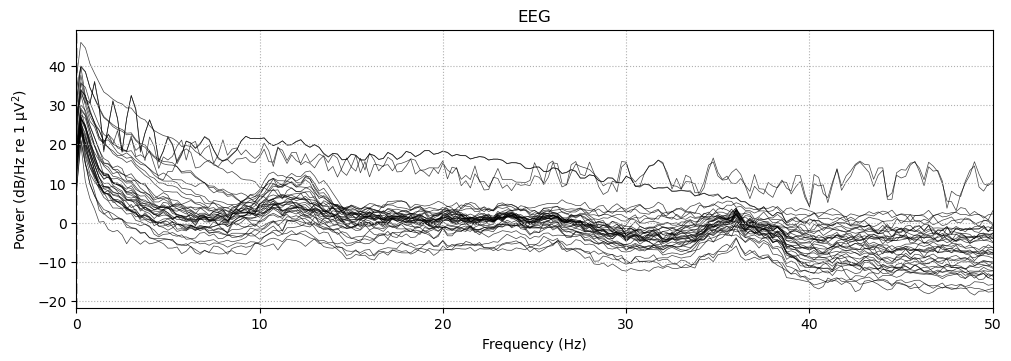

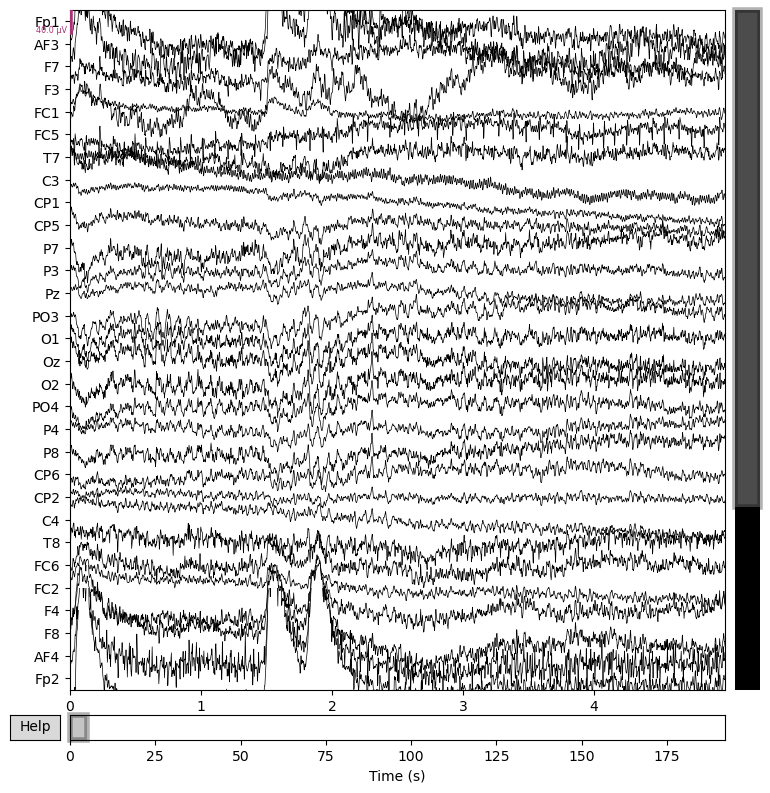

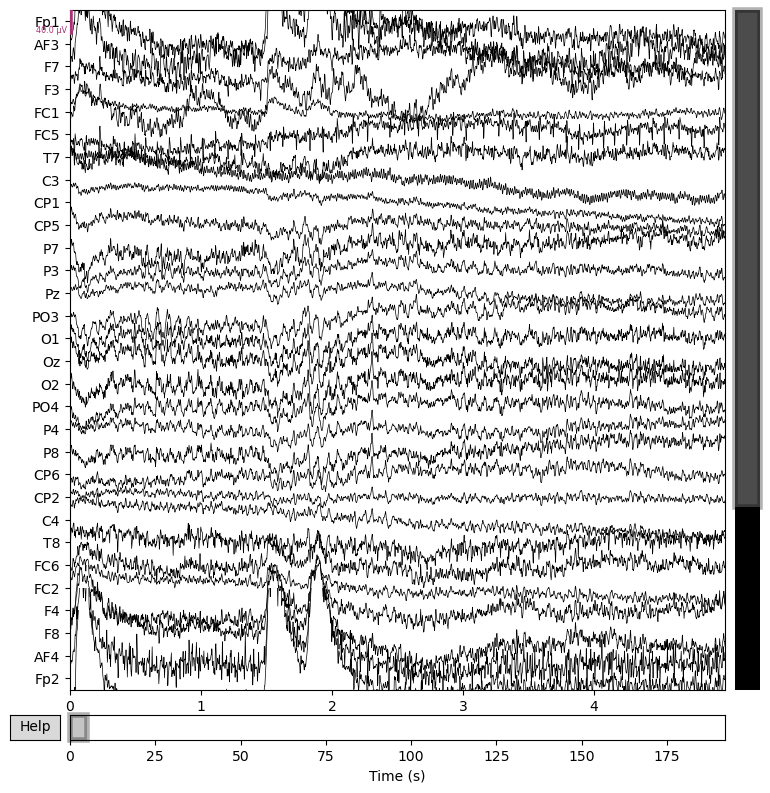

In [30]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)

In [31]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Fitting ICA to data using 40 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/v5/z7rgl2ms317g49cj9p8qglrh0000gn/T/ipykernel_16721/3318433905.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.8s.
    Using multitaper spectrum estimation with 7 DPSS windows


RuntimeError: No digitization points found.